In [1]:
# Reference:
#    https://peterroelants.github.io/posts/gaussian-process-kernels/
#    https://distill.pub/2019/visual-exploration-gaussian-processes/
#    http://gregorygundersen.com/blog/2019/06/27/gp-regression/
#
import numpy as np
from numpy.linalg import inv, det, cholesky
from numpy.linalg import solve as backsolve

import jax
from jax import grad, jit, vmap, device_put
import jax.numpy as jnp
import jax.numpy.linalg as jnp_linalg
from jax.experimental import optimizers
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Times New Roman'
cmap = plt.cm.get_cmap('bwr')

import sys
sys.path.append('../kernel')
from jaxkern import (rbf_kernel, linear_kernel, cov_se, cov_rq, cov_pe, cdist_sqeuclidean)

from plt_utils import plt_savefig, plt_scaled_colobar_ax

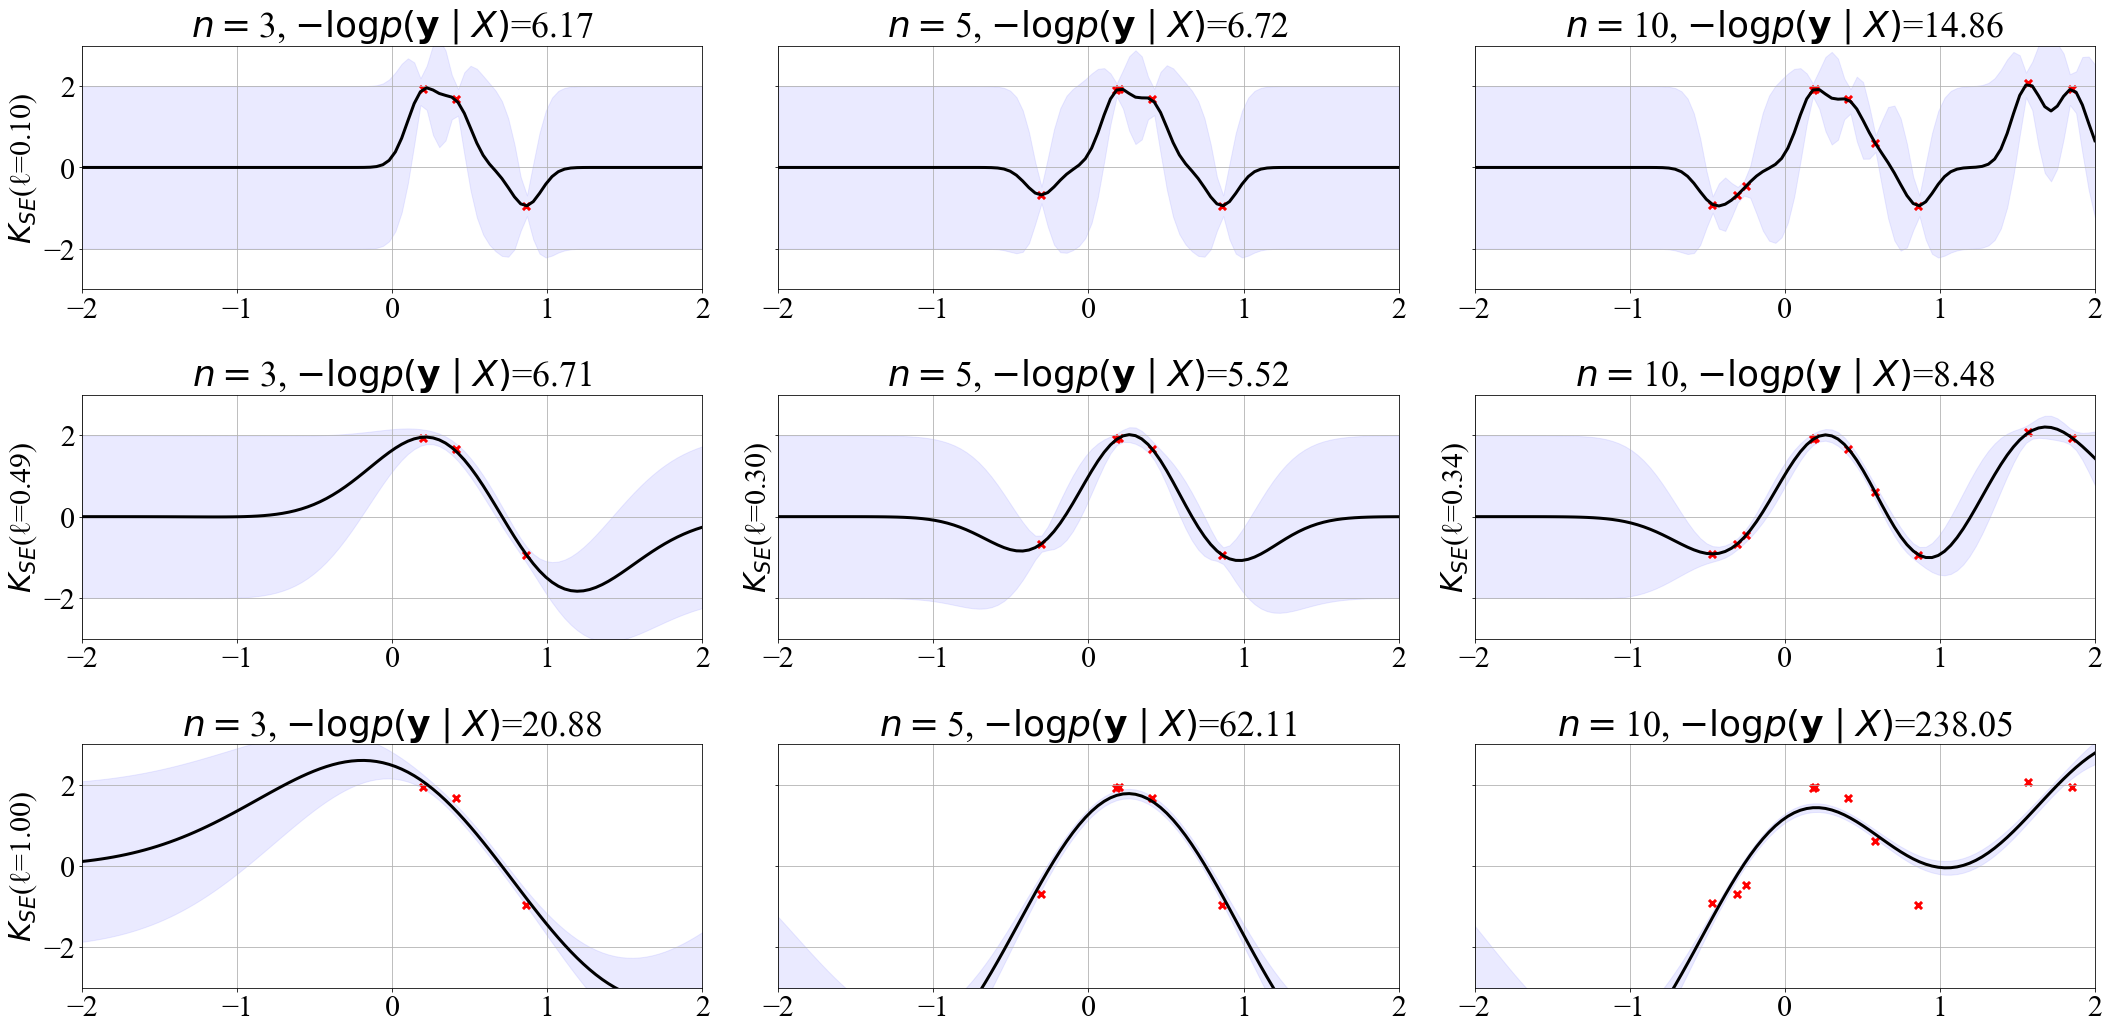

In [2]:

def gp_regression(X, y, Xt, k, σn):
    n = len(X)
    K  = k(X, X)+(σn**2)*np.eye(n)
    Km = k(X, Xt)
    Kt = k(Xt, Xt)
    Kinv = inv(K)
    μ = Km.T@Kinv@y_train
    Σ = Kt - Km.T@Kinv@Km
    logml = -(1/2)*y.T@Kinv@y - (1/2)*np.log(det(K)) - (n/2)*np.log(2*np.pi)
    return μ, Σ, logml

def gp_regression_chol(X, y, Xt, k, σn):
    n = len(X)
    K  = k(X, X)+(σn**2)*jnp.eye(n)
    Km = k(X, Xt)
    Kt = k(Xt, Xt)
    L = jnp_linalg.cholesky(K)
    α = jnp_linalg.solve(L.T, jnp_linalg.solve(L, y))
    μ = Km.T@α
    v = jnp_linalg.inv(L)@Km
    Σ = Kt - v.T@v
    logml = -(1/2)*y.T@α - jnp.sum(jnp.log(jnp.diag(L))) - (n/2)*jnp.log(2*jnp.pi)
    return μ, Σ, logml[0,0]

## Parameters 

xlim = (-2, 2)
ylim = (-3, 3)
n_train = 3
n_test = 100
σn = .1
ℓ = 1
ℓs = [.1, .3, 1]
train_sizes = [3, 5, 10]
lr = .002
num_steps = 10

def f_gen(x):
    return np.sin(x)+np.sin(x*5)+np.cos(x*3)

## Plotting

fig, axs = plt.subplots(3, 3, sharey=True)
fig.set_size_inches(30, 15)

np.random.seed(0)
X_test = np.expand_dims(np.linspace(*xlim, n_test), 1)
X_train_all = np.expand_dims(
    np.random.uniform(xlim[0], xlim[1], size=np.max(train_sizes)), 1)
ϵ_all = σn*np.random.rand(np.max(train_sizes), 1)

for i, ℓ in enumerate(ℓs):
    for j, n_train in enumerate(train_sizes):
        
        X_train = X_train_all[:n_train]
        ϵ = ϵ_all[:n_train]
        y_train = f_gen(X_train) + ϵ
        
        if i == 1:
            jX_train, jy_train, jX_test = device_put(X_train), device_put(y_train), device_put(X_test)
            def gpse_nll(params):
                k = lambda X, Y: cov_se(X, Y, ℓ=params['ℓ'])
                μ, Σ, logml = gp_regression_chol(jX_train, jy_train, jX_test, k, σn)
                return -logml
            gpse_nll = jit(gpse_nll)
            gpse_nll_grad = jit(grad(gpse_nll, argnums=0))
            params = {'ℓ': jnp.ones(1)}
            opt_init, opt_update, get_params = optimizers.sgd(lr)
            opt_state = opt_init(params)
            itercount = itertools.count()
            for _ in range(num_steps):
                params = get_params(opt_state)
                params_grad = gpse_nll_grad(params)
                opt_state = opt_update(next(itercount),params_grad, opt_state)
            ℓ = params['ℓ'][0]
        else:
            ℓ = ℓs[i]

        k = lambda X, Y: cov_se(X, Y, ℓ=ℓ)
        μ, Σ, logml = gp_regression_chol(X_train, y_train, X_test, k, σn)
        std = np.expand_dims(np.sqrt(np.diag(Σ)), 1)

        ax = axs[i, j]
        ax.plot(X_test, μ, color='k')
        ax.fill_between(X_test.squeeze(), (μ-2*std).squeeze(), (μ+2*std).squeeze(), alpha=.2, color=cmap(.3))
        ax.scatter(X_train, y_train, marker='x', color='r', s=50)
        ax.grid()
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_title('$n=$'+f'{n_train}'+', $-\log p(\mathbf{y}\mid X)$'+f'={-logml:.2f}')
        
        if j == 0 or i == 1:
            ax.set_ylabel('$K_{SE}$'+f'(ℓ={ℓ:.2f})')

fig.tight_layout()
plt_savefig(fig, 'summary/assets/plt_gp_regression_inference.png')